In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from tqdm import tqdm

In [14]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.randn(n)*sigma + mu

def get_noise_sampler():
    return lambda n,m: torch.rand(n,m)

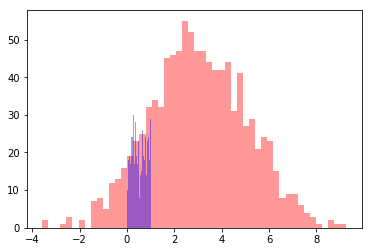

In [15]:
# plot histograms
dsampler = get_distribution_sampler(3, 2)
gsampler = get_noise_sampler()

n = 1000
data_samples = dsampler(n)
noise_samples = gsampler(n,1)[:,0]

bins = 50
plt.hist(data_samples, alpha=0.4, color='r', bins=bins)
plt.hist(noise_samples, alpha=0.4, color='b', bins=bins)
plt.show()

In [16]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return self.fc3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.sigmoid(self.fc3(x))

z_size = 20
G = Generator(z_size, 100, 1)
D = Discriminator(1, 100, 1)

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=20, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)
Discriminator(
  (fc1): Linear(in_features=1, out_features=100)
  (fc2): Linear(in_features=100, out_features=100)
  (fc3): Linear(in_features=100, out_features=1)
)


In [19]:
batch_size = 100
noise_samples = gsampler(batch_size, z_size)
noise_samples_v = Variable(noise_samples)
gen = G(noise_samples_v)
print(gen)
print(D(gen))

Variable containing:
-0.1653
-0.2313
-0.1713
-0.1676
-0.1803
-0.1260
-0.2087
-0.2016
-0.1531
-0.1826
-0.1917
-0.1721
-0.2053
-0.1929
-0.2117
-0.2143
-0.1970
-0.2365
-0.1411
-0.2261
-0.1786
-0.2301
-0.2096
-0.1930
-0.1707
-0.2170
-0.2227
-0.2154
-0.1824
-0.2035
-0.2910
-0.1691
-0.2065
-0.2063
-0.1942
-0.1499
-0.2270
-0.2711
-0.1864
-0.1696
-0.1690
-0.1847
-0.1457
-0.1856
-0.2322
-0.1939
-0.1890
-0.2108
-0.1730
-0.2467
-0.2166
-0.2186
-0.2074
-0.1503
-0.1726
-0.1646
-0.1376
-0.2055
-0.1780
-0.2005
-0.1554
-0.2260
-0.1912
-0.2520
-0.1498
-0.2201
-0.1514
-0.1461
-0.1923
-0.2179
-0.1494
-0.1863
-0.1827
-0.1667
-0.2510
-0.2303
-0.2064
-0.2374
-0.2205
-0.1932
-0.1720
-0.2492
-0.1739
-0.2120
-0.2330
-0.1803
-0.1529
-0.1874
-0.2195
-0.2214
-0.2214
-0.2001
-0.2588
-0.1874
-0.1985
-0.1862
-0.2202
-0.2387
-0.2287
-0.1794
[torch.FloatTensor of size 100x1]

Variable containing:
 0.5245
 0.5246
 0.5245
 0.5245
 0.5246
 0.5242
 0.5246
 0.5246
 0.5245
 0.5246
 0.5246
 0.5245
 0.5246
 0.5246
 0.5246
 0.

In [ ]:
nn.BCEWithLogitsLoss

In [33]:
G = Generator(z_size, 100, 1)
D = Discriminator(1, 100, 1)

lr = 1e-3
batch_size = 100
n_epochs = 10000

d_optimiser = optim.SGD(D.parameters(), lr=lr)
g_optimiser = optim.SGD(G.parameters(), lr=lr)

l = []
loss = nn.BCELoss()
zeros = Variable(torch.zeros(batch_size,1))
ones = Variable(torch.ones(batch_size,1))

for epoch in tqdm(range(n_epochs)):
  
    # discriminator training
    for i in range(5):
        D.zero_grad()
        real_data = Variable(dsampler(batch_size).view(-1,1))
        d_real = D(real_data)
        d_real_error = loss(d_real, ones)
        d_real_error.backward()

        z = Variable(gsampler(batch_size, z_size))
        fake = G(z).detach()
        d_fake = D(fake)
        d_fake_error = loss(d_fake, zeros)
        d_fake_error.backward()

        d_optimiser.step()
    
    # generator training
    G.zero_grad()
    gen_data = G(z)
    d_gen = D(gen_data)
    g_error = loss(d_gen, ones)
    g_error.backward()
    g_optimiser.step()
    
    l.append(fake.data.numpy())
    
l = np.array(l)
l = l.reshape(n_epochs,batch_size)

100%|██████████| 10000/10000 [03:05<00:00, 53.80it/s]


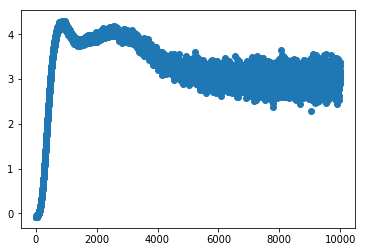

In [34]:
plt.scatter(np.arange(n_epochs), l.mean(axis=1))

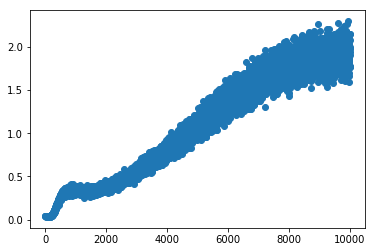

In [35]:
plt.scatter(np.arange(n_epochs), l.std(axis=1))

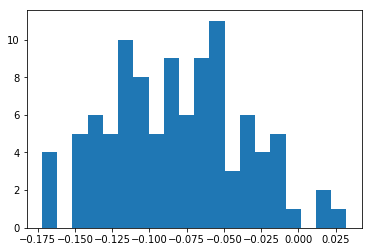

In [36]:
plt.hist(l[0], bins=20)
plt.show()

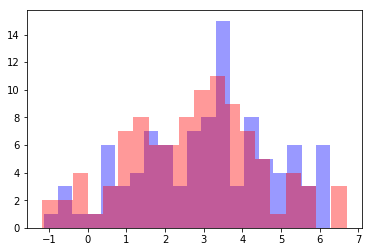

In [37]:
plt.hist(l[-1], bins=20, color='b', alpha=0.4)
plt.hist(np.random.normal(3,2,100), bins=20, color='r', alpha=0.4)
plt.show()